The equation with added terrain can be found here:

https://www.sciencedirect.com/science/article/pii/S1877750322002150

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import itertools, copy, sys
import pandas
np.set_printoptions(threshold=sys.maxsize)

import time
import pylab as pl
from IPython import display

import imageio.v2 as imageio
import io
import datetime
from PIL import Image

In [92]:
def load_terrain(filename, normalize_val):
    img = Image.open(filename).convert("L") # convert to 8 bit grayscale
    z = np.array(img, dtype=np.float32)
    max_val = np.max(z)
    z = (z / max_val) * normalize_val
    return z

In [93]:
def calculate_wave_old(i, j, u, u_t_2, t, C, g=9.81):
    h = 10/u.shape[0]
    X_1 = ((u[i+1, j] - u[i-1, j]) / 2*h)**2
    X_2 = u[i, j] * (
        (u[i+1, j]-2*u[i, j]+ u[i-1, j]) / h**2
    )
    X_3 = ((u[i, j+1] - u[i, j-1]) / 2*h)**2
    X_4 = u[i, j] * (
        (u[i, j+1]-2*u[i, j]+ u[i, j-1]) / h**2
    )

    X = X_1 + X_2 + X_3 + X_4

    # u_t = u_(t-1) + (u_(t-1) - u_(t-2)) + g * Δt^2 * ∇(u_(t-1) * ∇(u_(t-1)))
    # X = ∇(u_(t-1) * ∇(u_(t-1)))

    val = u[i, j] + C * (u[i, j] - u_t_2[i, j]) + g * (t**2) * X
    return val

In [94]:
def calculate_wave_new(i, j, u, u_t_2, t, C, z, g=9.81):
    h = 10/u.shape[0]
    X_1 = (((u[i+1,j] - z[i+1,j]) - (u[i-1,j] - z[i-1,j])) / (2*h)) * ((u[i+1,j] - u[i-1,j]) / (2*h)) 
    X_2 = (u[i,j] - z[i,j]) * (u[i+1,j] - 2 * u[i,j] + u[i-1,j]) / (h**2)
    X_3 = (((u[i,j+1] - z[i,j+1]) - (u[i,j-1] - z[i,j-1])) / (2*h)) * ((u[i,j+1] - u[i,j-1]) / (2*h))
    X_4 = (u[i,j] - z[i,j]) * ((u[i,j+1] - 2 * u[i,j] + u[i,j-1]) / (h**2))

    X = X_1 + X_2 + X_3 + X_4

    # u_t = u_(t-1) + (u_(t-1) - u_(t-2)) + g * Δt^2 * ∇((u_(t-1) - z) * ∇(u_(t-1)))
    # X = ∇((u_(t-1) - z) * ∇(u_(t-1)))

    val = u[i, j] + C * (u[i, j] - u_t_2[i, j]) + g * (t**2) * X
    return val

In [95]:
def wave_step(center, u_t_1, u_t_2, t, C, z, g=9.81):
   x, y = center
   size = u_t_1.shape[0]
   u_new = np.full(shape = (size,size), fill_value = 2, dtype = float)

   for i in range(1, size-1):
      for j in range(1, size-1):
         u_new[i, j] = calculate_wave_new(i, j, u_t_1, u_t_2, t, C, z, g)

        #  r = np.sqrt((i-x)**2 + (j-y)**2)
        #  u_new[i, j] += (t*t*(2 + 2 * np.exp(-(r**2))))
        #  u_new[i, j] += (t*t*2)

   return u_new, u_t_1

In [96]:
def create_board(size, center):
    x, y = center
    delta = 10 / size
    x *= delta
    y *= delta
    board = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            r = np.sqrt((i*delta-x)**2 + (j*delta-y)**2)
            board[i, j] = 2 + 2 * np.exp(-(r**2))

    return board

In [97]:
def wave_simulation(size, center, iterations, t, C, z):
    u_t_1 = create_board(size, center)
    u_t_2 = create_board(size, center)

    frames = []

    # plt.figure()
    # plt.colorbar()
    for i in range(iterations-1):
        u_t_1, u_t_2 = wave_step(center, u_t_1, u_t_2, t, C, z)

        if i % 10 == 0:
          fig = plt.figure()
          plt.imshow(u_t_1)

          display.clear_output(wait=True)
          display.display(pl.gcf())
            
          buf = io.BytesIO()
          plt.savefig(buf, format='png', bbox_inches='tight')
          buf.seek(0)
          plt.close(fig)
        
          frames.append(imageio.imread(buf))
          buf.close()
          print(f"Step {i + 10} of {iterations} -> frame {i // 10 + 1} of {iterations // 10}")

    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    imageio.mimsave("./gifs/t_" + timestamp + ".gif", frames, fps=20)

    return u_t_1

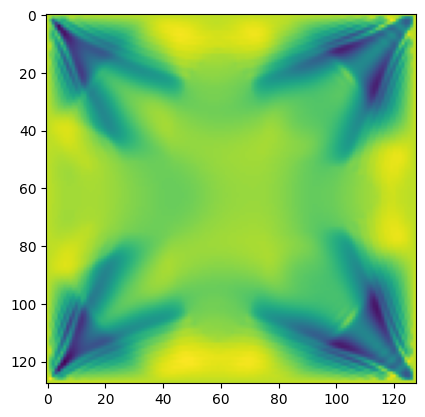

Step 2000 of 2000 -> frame 200 of 200
2.0
(128, 128)


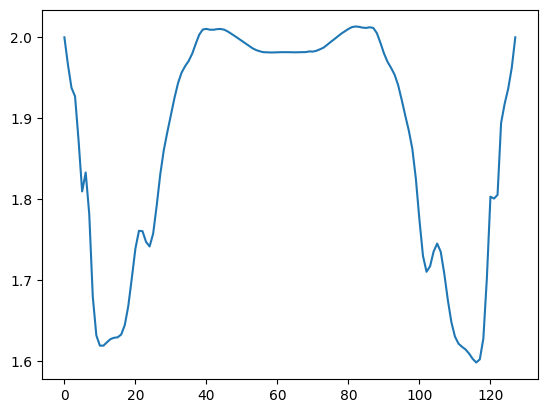

In [98]:
b = wave_simulation(128, (64, 64), 2000, 0.001, 0.999, load_terrain("./terrains/syntetic.png", 1.3))
# plt.imshow(b)
# plt.colorbar()
# print(b[64, 64])
print(b[0,60])
# print(pandas.DataFrame(b))

print(b.shape)
plt.plot(b[:, 10])

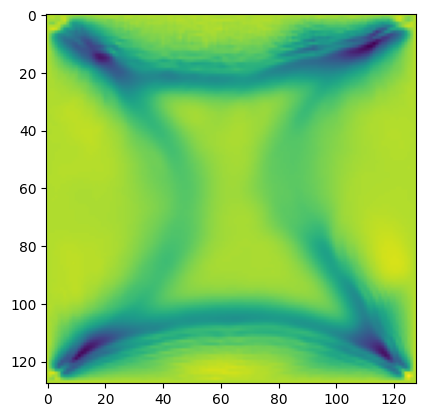

Step 2000 of 2000 -> frame 200 of 200
2.0
(128, 128)


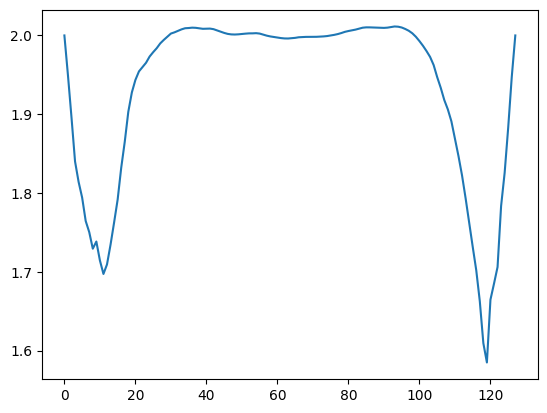

In [99]:
b = wave_simulation(128, (64, 64), 2000, 0.001, 0.999, load_terrain("./terrains/natural.png", 1.3))
# plt.imshow(b)
# plt.colorbar()
# print(b[64, 64])
print(b[0,60])
# print(pandas.DataFrame(b))

print(b.shape)
plt.plot(b[:, 10])